In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import json
from collections import namedtuple

In [2]:
def plot_stuff(title, predicted, expert, figsize=(18, 10)):
    fig=plt.figure(figsize=figsize)
    plt.title(title)
    plt.ylabel('Diff')
    plt.xlabel('Count')
    plt.plot(expert, label='expert', alpha=1.0)
    plt.plot(predicted, label='predicted', alpha=0.3)
    plt.grid(axis='y')
    plt.legend(loc='best')
    plt.show()
    
def plot_one_stuff(title, stuff, figsize=(18, 10)):
    fig=plt.figure(figsize=figsize)
    plt.title(title)
    plt.ylabel('Diff')
    plt.xlabel('Count')
    plt.plot(stuff, label='stuff', alpha=1.0)
    plt.grid(axis='y')
    plt.legend(loc='best')
    plt.show()
    
def get_namedtuple_from_json_string(line):
    return json.loads(line, object_hook=lambda d: namedtuple('stuff', d.keys())(*d.values()))

def read_training_telemetry(filename):
    telemetry_list = []
    with open(filename) as file:
        for line in file:
            telemetry_list.append(get_namedtuple_from_json_string(line))

    return pd.DataFrame.from_records(telemetry_list, columns=telemetry_list[0]._fields)

In [6]:
df = pd.read_csv('../../training/2020_01_19_test_3_with_expert.csv')
#df = df[8000:25000]

print(df.shape)
print(df.columns.values)

(4386, 16)
['Unnamed: 0' 'p' 'p2' 'c' 'c2' 'cs' 'cg' 'ct' 'cb' 'b' 'sa'
 'd_gear_expert' 'd_steering_expert' 'd_throttle_expert'
 'd_braking_expert' 'supervisor_expert']


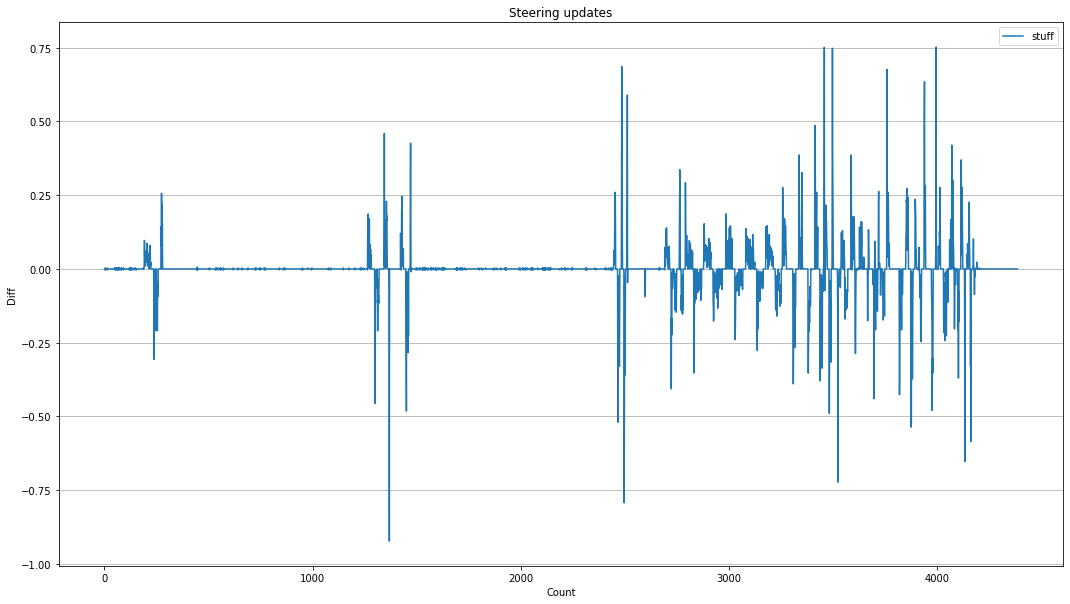

In [7]:
plot_one_stuff('Steering updates', df.d_steering_expert)

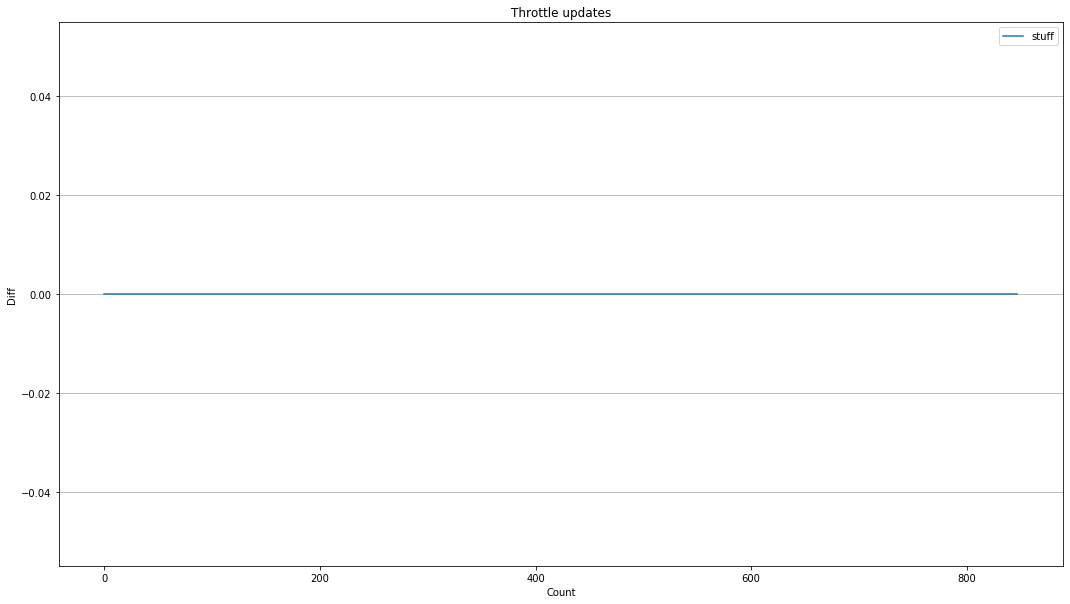

In [11]:
plot_one_stuff('Throttle updates', df.d_throttle_expert)

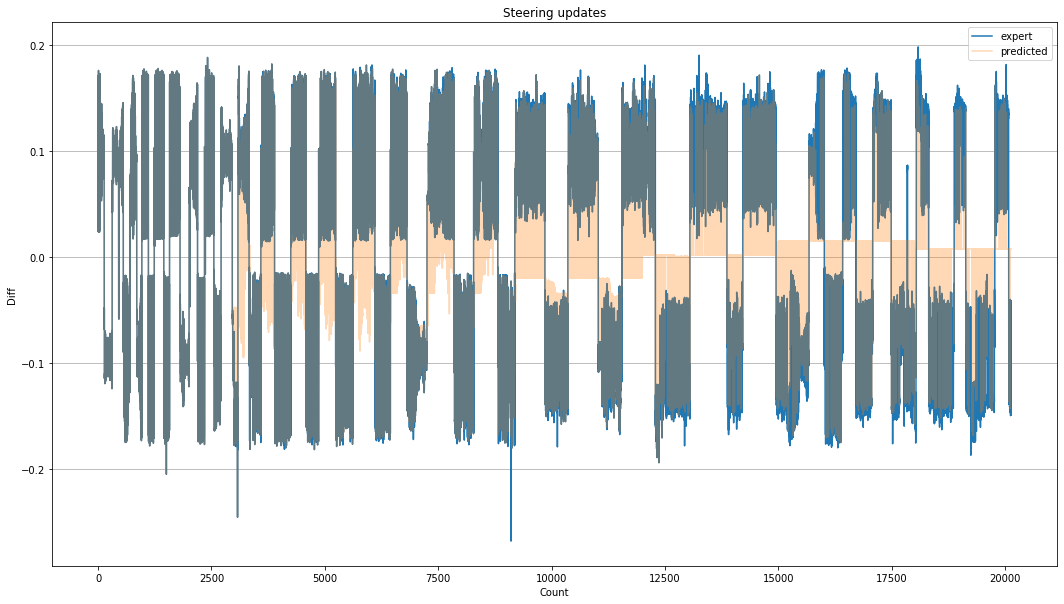

In [7]:
plot_stuff('Steering updates', df.d_steering_pred, df.d_steering_exp)

In [ ]:
plot_stuff('Throttle updates', df.d_throttle_pred, df.d_throttle_exp)

In [ ]:
plot_stuff('Braking updates', df.d_braking_pred, df.d_braking_exp)

In [ ]:
plot_stuff('Gear', df.d_gear_pred, df.d_gear_exp)